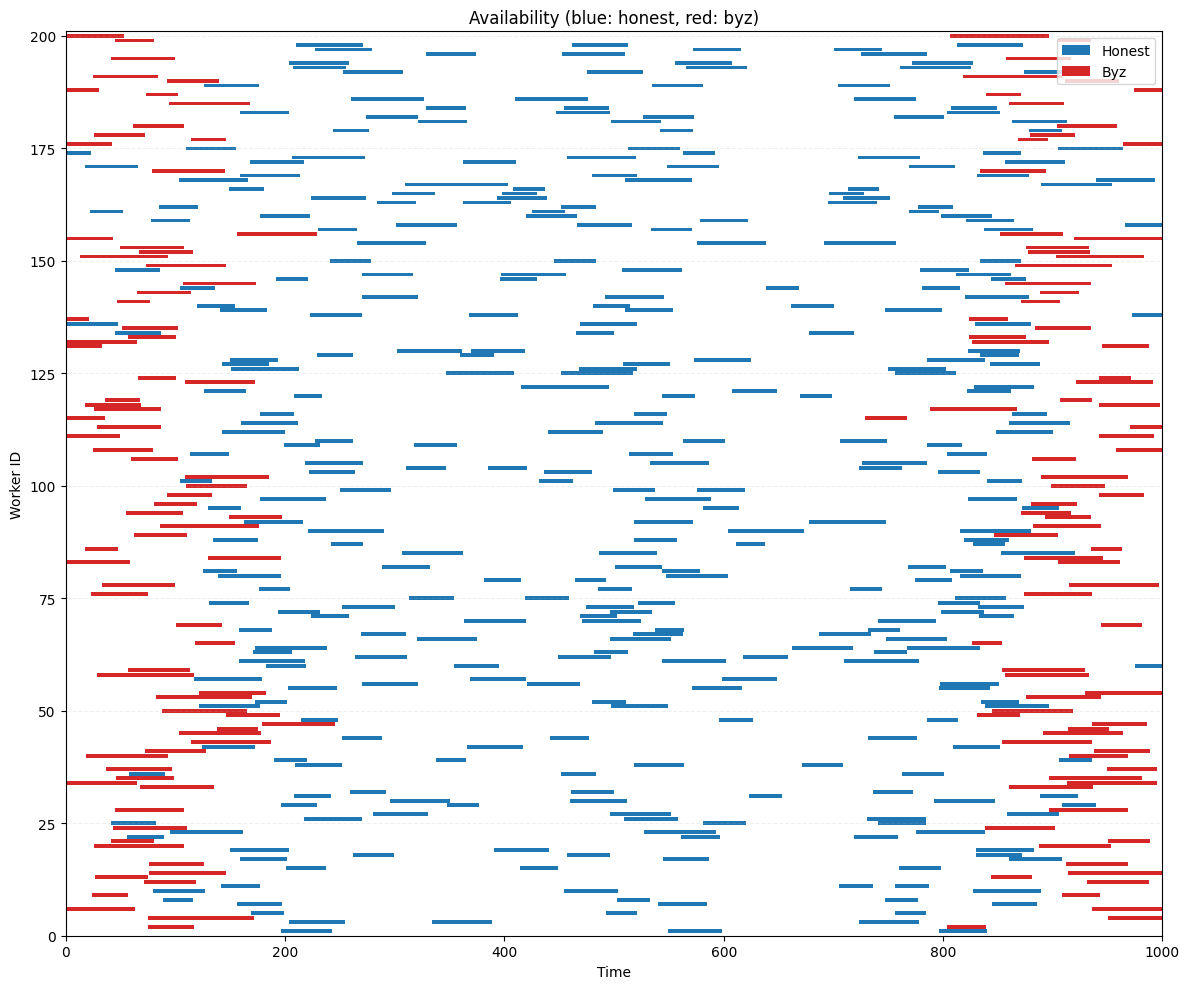

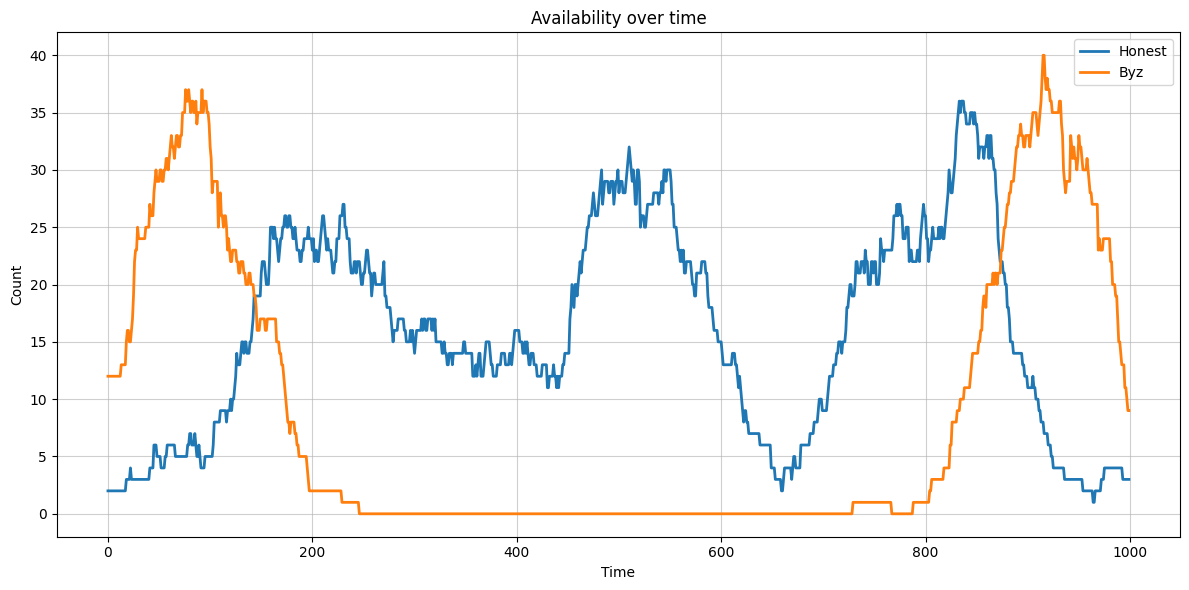

Safe init — Acc: 15.26%, Loss: 2.3024
[t=20] Batch 1 → Acc: 9.95%, Loss: 2.3032
[t=48] Batch 2 → Acc: 9.95%, Loss: 2.3032
[t=65] Batch 3 → Acc: 9.95%, Loss: 2.3031
[t=80] Batch 4 → Acc: 9.95%, Loss: 2.3032
[t=90] Batch 5 → Acc: 9.95%, Loss: 2.3032
[t=108] Batch 6 → Acc: 9.95%, Loss: 2.3032
[t=124] Batch 7 → Acc: 9.95%, Loss: 2.3032
[t=141] Batch 8 → Acc: 9.95%, Loss: 2.3032
[t=160] Batch 9 → Acc: 9.95%, Loss: 2.3032
[t=177] Batch 10 → Acc: 9.95%, Loss: 2.3032
-4.728482805469894e-16
0.0
-1.1699368255722328e-07
0.0
ROLLBACK — Acc 15.26%, Loss 2.3024
[t=196] Batch 11 → Acc: 40.60%, Loss: 2.0022
[t=218] Batch 12 → Acc: 34.24%, Loss: 1.8882
[t=237] Batch 13 → Acc: 62.31%, Loss: 1.4783
[t=265] Batch 14 → Acc: 68.00%, Loss: 1.0719
[t=312] Batch 15 → Acc: 76.38%, Loss: 0.7374
[t=373] Batch 16 → Acc: 78.57%, Loss: 0.6353
[t=418] Batch 17 → Acc: 80.42%, Loss: 0.5658
[t=471] Batch 18 → Acc: 83.49%, Loss: 0.5020
[t=496] Batch 19 → Acc: 86.06%, Loss: 0.4482
[t=524] Batch 20 → Acc: 87.22%, Loss: 0.3

KeyboardInterrupt: 

In [25]:
import random
import math
import copy

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms

import byzfl

# ------------------------------------------------------------------------------
def merge_intervals(intervals):
    if not intervals:
        return []
    intervals.sort()
    merged = [intervals[0]]
    for current in intervals[1:]:
        last = merged[-1]
        if current[0] <= last[1]:
            merged[-1] = (last[0], max(last[1], current[1]))
        else:
            merged.append(current)
    return merged

# Gaussian availability for honest and Byzantine workers

def generate_gaussian_availability(total_time_steps, worker_id, num_workers,
                                   std_dev_ratio=0.08, min_processing_time=3,
                                   smoothing_window=10):
    peak_means = [0.2, 0.5, 0.8]
    std_dev = int(std_dev_ratio * total_time_steps)
    availability_periods = []
    for mean_ratio in peak_means:
        mean = int(mean_ratio * total_time_steps)
        start_time = int(np.random.normal(loc=mean, scale=std_dev))
        start_time = max(0, min(start_time, total_time_steps - min_processing_time*3))
        duration = random.randint(min_processing_time*3,
                                  min(min_processing_time*5, total_time_steps - start_time))
        availability_periods.append((start_time, start_time + duration))
    merged = merge_intervals(availability_periods)
    smoothed = [(max(0, s-smoothing_window), min(total_time_steps, e+smoothing_window)) for s,e in merged]
    return merge_intervals(smoothed)

def generate_gaussian_byzantine_availability(
    total_time_steps, worker_id, num_workers,
    std_dev_ratio=0.05, min_processing_time=3,
    smoothing_window=10
):
    off_peak_means = [0.07, 0.9]
    std_dev = int(std_dev_ratio * total_time_steps)
    availability_periods = []
    for mean_ratio in off_peak_means:
        mean = int(mean_ratio * total_time_steps)
        start = int(np.random.normal(loc=mean, scale=std_dev))
        start = max(0, min(start, total_time_steps - min_processing_time*4))
        duration = random.randint(
            min_processing_time*4,
            min(min_processing_time*8, total_time_steps - start)
        )
        availability_periods.append((start, start + duration))
    merged = merge_intervals(availability_periods)
    smoothed = [(max(0, s-smoothing_window), min(total_time_steps, e+smoothing_window)) for s,e in merged]
    return merge_intervals(smoothed)

# ------------------------------------------------------------------------------
# LeNet-like model
class LeNetLike(nn.Module):
    def __init__(self):
        super(LeNetLike, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64*7*7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ------------------------------------------------------------------------------
# Batch manager
class BatchManager:
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indices = list(range(len(dataset)))
        random.shuffle(self.indices)
        self.sampler = SubsetRandomSampler(self.indices)
        self.loader = iter(DataLoader(dataset, batch_size=batch_size, sampler=self.sampler))

    def get_next_batch(self):
        try:
            return next(self.loader)
        except StopIteration:
            random.shuffle(self.indices)
            self.sampler = SubsetRandomSampler(self.indices)
            self.loader = iter(DataLoader(self.dataset, batch_size=self.batch_size, sampler=self.sampler))
            return next(self.loader)

# ------------------------------------------------------------------------------
# Worker classes
class Worker:
    def __init__(self, model, device, worker_id, availability_periods, processing_time):
        self.is_byzantine = False
        self.device = device
        self.worker_id = worker_id
        self.availability_periods = availability_periods
        self.processing_time = processing_time
        self.model = model.to(device)
        self.criterion = nn.CrossEntropyLoss()
        self.finish_time = None
        self.current_batch_info = None
        self._pending = None

    def is_available(self, current_time):
        for s,e in self.availability_periods:
            if s <= current_time < e and (self.finish_time is None or current_time >= self.finish_time):
                return (current_time + self.processing_time) <= e
        return False

    def start_computation(self, current_time, batch_info, data, targets):
        if self.current_batch_info != batch_info:
            self.current_batch_info = batch_info
            self.finish_time = current_time + self.processing_time
            self._pending = (data, targets)

    def has_finished(self, current_time):
        if self.finish_time == current_time and self._pending is not None:
            data, targets = self._pending
            self._pending = None
            grads, bi = self.compute_gradient(data, targets)
            return True, grads, bi
        return False, None, None

    def compute_gradient(self, data, targets):
        data, targets = data.to(self.device), targets.to(self.device)
        self.model.zero_grad()
        outputs = self.model(data)
        loss = self.criterion(outputs, targets)
        loss.backward()
        grads = {n: p.grad.detach().clone() for n,p in self.model.named_parameters()}
        return grads, self.current_batch_info

    def update_model(self, state):
        self.model.load_state_dict(state)

class ByzantineWorker(Worker):
    def __init__(self, model, device, worker_id, availability_periods, processing_time):
        super().__init__(model, device, worker_id, availability_periods, processing_time)
        self.is_byzantine = True

    def compute_gradient(self, data, targets):
        honest_grads, bi = super().compute_gradient(data, targets)
        if random.random() < 0.5:
            mag = random.uniform(0.5e6, 9e6)
            corrupted = {n: torch.full_like(g, mag) for n,g in honest_grads.items()}
        else:
            flats, shapes = [], []
            for n,g in honest_grads.items(): flats.append(g.view(-1)); shapes.append((n, g.shape))
            g = torch.cat(flats)
            r = torch.randn_like(g)
            proj = (torch.dot(g,r)/torch.dot(g,g))*g if torch.dot(g,g)>0 else torch.zeros_like(g)
            u = r - proj
            if u.norm()>0: u = u*(g.norm()/u.norm())
            theta = random.uniform(math.pi/2, 3*math.pi/2)
            vec = math.cos(theta)*g + math.sin(theta)*u
            corrupted = {}
            idx = 0
            for n,sh in shapes:
                num = int(torch.tensor(sh).prod().item())
                corrupted[n] = vec[idx:idx+num].view(sh); idx+=num
        return corrupted, bi

# ------------------------------------------------------------------------------
class Server:
    def __init__(self, dataset, batch_size=64, mini_batch_size=16, lr=0.005,
                 verbose=False, aggregation_strategy='majority_vote', vote_k=3, preagg=None, f=0):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = LeNetLike().to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.batch_manager = BatchManager(dataset, batch_size)
        self.mini_batch_size = mini_batch_size
        self.current_batch_id = 0
        self.received_gradients = {}
        self.verbose = verbose
        self.aggregation_strategy = aggregation_strategy
        self.vote_k = vote_k
        self.preagg = preagg
        self.f = f
        self.total_raw_compute_time = 0
        self.total_useful_compute_time = 0
        self.total_waste_compute_time = 0
        self.current_full_batch_compute_time = 0
        self.criterion = nn.CrossEntropyLoss()

    def _gradients_are_equal(self, g1, g2, rtol=1e-3, atol=1e-8):
        for k in g1:
            if not torch.allclose(g1[k], g2[k], rtol=rtol, atol=atol): return False
        return True

    def get_new_complete_batch(self, current_time):
        data, targets = self.batch_manager.get_next_batch()
        self.current_batch_id += 1
        self.current_full_batch_compute_time = 0
        mbs = [(data[i:i+self.mini_batch_size], targets[i:i+self.mini_batch_size])
               for i in range(0, data.size(0), self.mini_batch_size)]
        self.current_mini_batches = {i: mbs[i] for i in range(len(mbs))}
        self.received_gradients = {}
        if self.verbose:
            print(f"[t={current_time}] New batch {self.current_batch_id}")

    def register_gradient(self, grads, batch_info, wid, current_time, pt, is_byzantine=False):
        bid, mid = batch_info
        if bid != self.current_batch_id: return
        if self.aggregation_strategy == 'majority_vote':
            lst = self.received_gradients.setdefault(mid, [])
            if len(lst) < self.vote_k:
                lst.append(grads)
                self.total_raw_compute_time += pt
                self.current_full_batch_compute_time += pt
                if self.verbose:
                    tag = ' (B)' if is_byzantine else ''
                    print(f"[t={current_time}] Grad {mid} w{wid}{tag}")
        else:
            if mid in self.received_gradients: return
            self.received_gradients[mid] = grads
            self.total_raw_compute_time += pt
            self.current_full_batch_compute_time += pt
            if self.verbose:
                tag = ' (B)' if is_byzantine else ''
                print(f"[t={current_time}] Grad {mid} w{wid}{tag}")

    def aggregate_and_update(self):
        # wait condition
        if self.aggregation_strategy == 'majority_vote':
            if any(len(self.received_gradients.get(mid, [])) < self.vote_k
                   for mid in self.current_mini_batches):
                if self.verbose: print("⏳ waiting votes...")
                return False
        else:
            if len(self.received_gradients) != len(self.current_mini_batches):
                if self.verbose: print("⚠️ Not enough grads.")
                return False
        # preagg
        pre = None
        if self.preagg == 'NNM': pre = byzfl.NNM(f=self.f)
        elif self.preagg == 'Bucketing': pre = byzfl.Bucketing(s=1)
        elif self.preagg == 'ARC': pre = byzfl.ARC(f=self.f)
        # aggregate
        aggs = {}
        if self.aggregation_strategy == 'majority_vote':
            winners = {}
            for mid, lst in self.received_gradients.items():
                best, bc = None, -1
                for g in lst:
                    c = sum(self._gradients_are_equal(g,h) for h in lst)
                    if c>bc: best, bc = g, c
                winners[mid] = best
            for name,param in self.model.named_parameters():
                M = torch.stack([winners[mid][name].view(-1)
                                 for mid in sorted(self.current_mini_batches)])
                aggs[name] = M.mean(dim=0).view(param.size())
        else:
            for name,param in self.model.named_parameters():
                Gs = [self.received_gradients[i][name]
                      for i in sorted(self.current_mini_batches)]
                G = torch.stack(Gs).view(len(Gs), -1)
                if pre: G = pre(G)
                if self.aggregation_strategy=='trimmed_mean':
                    flat = byzfl.TrMean(f=max(self.f,(len(Gs)//2)-1))(G)
                else:
                    flat = byzfl.Average()(G)
                aggs[name] = flat.view(param.size())
        # apply
        self.optimizer.zero_grad()
        for name,param in self.model.named_parameters(): param.grad = aggs[name]
        self.optimizer.step()
        if self.verbose:
            print(f"Updated model batch {self.current_batch_id}")
        return True

    def evaluate_acc(self, loader):
        self.model.eval()
        correct=0; total=0
        with torch.no_grad():
            for x,t in loader:
                x,t=x.to(self.device),t.to(self.device)
                pred=self.model(x).argmax(dim=1)
                total+=t.size(0)
                correct+=(pred==t).sum().item()
        self.model.train()
        return 100*correct/total

    def evaluate_loss(self, loader):
        self.model.eval()
        tot_loss=0; tot=0
        with torch.no_grad():
            for x,t in loader:
                x,t=x.to(self.device),t.to(self.device)
                l=self.criterion(self.model(x), t)
                b=x.size(0)
                tot_loss+=l.item()*b; tot+=b
        self.model.train()
        return tot_loss/tot

    def report_compute_metrics(self):
        tot=self.total_raw_compute_time
        use=self.total_useful_compute_time
        waste=self.total_waste_compute_time
        rate=100*waste/tot if tot else 0
        print(f"Raw: {tot}, Useful: {use}, Waste: {waste}, Rate: {rate:.2f}%")

# ------------------------------------------------------------------------------
def create_workers(num_worker, byz_idx, steps, server):
    workers=[]
    for i in range(1,num_worker+1):
        pt = random.randint(2,10)
        if i in byz_idx:
            av = generate_gaussian_byzantine_availability(steps,i,num_worker,min_processing_time=pt)
            w=ByzantineWorker(server.model,server.device,i,av,pt)
        else:
            av = generate_gaussian_availability(steps,i,num_worker,min_processing_time=pt)
            w=Worker(server.model,server.device,i,av,pt)
        workers.append(w)
    return workers

class SafePointSimulator:
    def __init__(self, server, workers, val_loader, test_loader, total_time_steps=1000, group_size=3):
        self.server=server
        self.workers=workers
        self.val_loader=val_loader
        self.test_loader=test_loader
        self.total_time_steps=total_time_steps
        self.group_size=group_size
        self.global_time=0
        self.in_progress=[]
        self.server.get_new_complete_batch(self.global_time)
        self.plot_worker_availability()

    def plot_worker_availability(self):
        num=len(self.workers)
        fig,ax=plt.subplots(figsize=(12,max(6,min(0.05*num,20))))
        for w in self.workers:
            c='tab:red' if w.is_byzantine else 'tab:blue'
            for s,e in w.availability_periods:
                ax.broken_barh([(s,e-s)],(w.worker_id-0.4,0.8),facecolors=c)
        ax.set_xlabel('Time'); ax.set_ylabel('Worker ID')
        ax.set_title('Availability (blue: honest, red: byz)')
        ax.set_xlim(0,self.total_time_steps)
        ax.set_ylim(0,max(w.worker_id for w in self.workers)+1)
        ax.grid(True,axis='y',linestyle='--',alpha=0.2)
        from matplotlib.patches import Patch
        ax.legend([Patch(facecolor='tab:blue'),Patch(facecolor='tab:red')],['Honest','Byz'],loc='upper right')
        plt.tight_layout(); plt.show()
        # cumulative
        honest=[0]*self.total_time_steps
        byz=[0]*self.total_time_steps
        for w in self.workers:
            tgt = byz if w.is_byzantine else honest
            for s,e in w.availability_periods:
                for t in range(s,min(e,self.total_time_steps)):
                    tgt[t]+=1
        plt.figure(figsize=(12,6))
        plt.plot(range(self.total_time_steps), honest, linewidth=2)
        plt.plot(range(self.total_time_steps), byz, linewidth=2)
        plt.xlabel('Time'); plt.ylabel('Count')
        plt.title('Availability over time')
        plt.legend(['Honest','Byz']); plt.grid('--',alpha=0.6)
        plt.tight_layout(); plt.show()

    def run(self, verbose=False, eval_interval=10):
        # initial safe point
        safe_m = copy.deepcopy(self.server.model.state_dict())
        safe_o = copy.deepcopy(self.server.optimizer.state_dict())
        safe_acc = self.server.evaluate_acc(self.val_loader)
        safe_loss= self.server.evaluate_loss(self.val_loader)
        print(f"Safe init — Acc: {safe_acc:.2f}%, Loss: {safe_loss:.4f}")
        #global_accs=[safe_acc]
        #global_losses=[safe_loss]
        group_updates=[]; group_losses=[]; group_durs=[]
        count=0
        tpts=[]; accs=[]
        k=self.server.vote_k
        while self.global_time < self.total_time_steps:
            # collect finished
            for w in self.in_progress[:]:
                done, grads, bi = w.has_finished(self.global_time)
                if not done: continue
                self.server.register_gradient(grads, bi, w.worker_id, self.global_time, w.processing_time, w.is_byzantine)
                self.in_progress.remove(w)
            # aggregate
            if self.server.aggregate_and_update():
                acc = self.server.evaluate_acc(self.val_loader)
                vl = self.server.evaluate_loss(self.val_loader)
                print(f"[t={self.global_time}] Batch {self.server.current_batch_id} → Acc: {acc:.2f}%, Loss: {vl:.4f}")
                group_updates.append(acc) 
                group_losses.append(vl)
                group_durs.append(self.server.current_full_batch_compute_time)
                count+=1
                self.server.get_new_complete_batch(self.global_time)
                self.in_progress.clear()
                if count==self.group_size:
                    eps_acc = 1e-5
                    x_acc = np.arange(len(group_updates))
                    slope_acc, _ = np.polyfit(x_acc, np.array(group_updates), 1)
                    print(slope_acc)
                    slope_acc = slope_acc if abs(slope_acc) > eps_acc else 0.0
                    delta_acc = group_updates[-1] - safe_acc
                    
                    print(slope_acc)
                    ok_acc = (slope_acc > 0) and (delta_acc > 0)
                    # 3b) pente linéaire de -loss locale + gain absolu
                    eps_loss = 1e-5
                    x_loss = np.arange(len(group_losses))
                    slope_loss, _ = np.polyfit(x_loss, -np.array(group_losses), 1)
                    print(slope_loss)
                    slope_loss = slope_loss if abs(slope_loss) > eps_loss else 0.0
                    delta_loss = safe_loss - group_losses[-1]
                    print(slope_loss)
                    ok_loss = (slope_loss > 0) and (delta_loss > 0)

                    # 3c) décision combinée : on exige progression sur les deux
                    accept = ok_acc and ok_loss
                    total_t = sum(group_durs)
                    if accept:
                        safe_m=copy.deepcopy(self.server.model.state_dict())
                        safe_o=copy.deepcopy(self.server.optimizer.state_dict())
                        safe_acc=group_updates[-1]
                        safe_loss=group_losses[-1]
                        self.server.total_useful_compute_time += total_t
                        print(f"ACCEPT — Acc {safe_acc:.2f}%, Loss {safe_loss:.4f}")
                    else:
                        self.server.model.load_state_dict(safe_m)
                        self.server.optimizer.load_state_dict(safe_o)
                        self.server.total_waste_compute_time += total_t
                        print(f"ROLLBACK — Acc {safe_acc:.2f}%, Loss {safe_loss:.4f}")
                    group_updates.clear(); group_losses.clear(); group_durs.clear(); count=0
            # assign new
            avail=[w for w in self.workers if w.is_available(self.global_time) and w not in self.in_progress]
            for mid,mb in self.server.current_mini_batches.items():
                if self.server.aggregation_strategy=='majority_vote':
                    got = len(self.server.received_gradients.get(mid, []))
                else:
                    got = 1 if mid in self.server.received_gradients else 0
                while got < k and avail:
                    w = avail.pop(0)
                    w.update_model(copy.deepcopy(self.server.model.state_dict()))
                    data,tgt = mb
                    w.start_computation(self.global_time, (self.server.current_batch_id, mid), data, tgt)
                    self.in_progress.append(w)
                    got +=1
            # periodic test eval
            if self.global_time % eval_interval==0:
                test_acc = self.server.evaluate_acc(self.test_loader)
                tpts.append(self.global_time); accs.append(test_acc)
            self.global_time+=1
        # restore
        self.server.model.load_state_dict(safe_m)
        self.server.optimizer.load_state_dict(safe_o)
        final = self.server.evaluate_acc(self.test_loader)
        print(f"Final acc: {final:.2f}%")
        plt.figure(figsize=(10,5)); plt.plot(tpts, accs, linewidth=2)
        plt.xlabel('Time'); plt.ylabel('Accuracy (%)'); plt.title('Test Acc over time')
        plt.grid('--',alpha=0.6); plt.tight_layout(); plt.show()
        return tpts, accs, final

# ----------------------------------------------------------------------------
def run_experiment(num_cycles=1, num_runs=1, steps_per_cycle=1000,
                   byzantine_ratio=0.0, aggregation_strategy='majority_vote', vote_k=3, preagg=None):
    trajectories = {}
    num_worker = 200
    trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    full_train = datasets.MNIST('./data', train=True, download=True, transform=trans)
    test_ds = datasets.MNIST('./data', train=False, download=True, transform=trans)
    n_total=len(full_train)
    n_val=int(0.2*n_total)
    perm=torch.randperm(n_total)
    val_idx, train_idx = perm[:n_val].tolist(), perm[n_val:].tolist()
    val_loader = DataLoader(full_train, batch_size=200, sampler=SubsetRandomSampler(val_idx))
    test_loader=DataLoader(test_ds, batch_size=120, shuffle=False)
    for ratio in [byzantine_ratio]:
        server = Server(full_train, batch_size=640, mini_batch_size=64,
                        verbose=False, aggregation_strategy=aggregation_strategy,
                        vote_k=vote_k, preagg=preagg)
        byz = set(random.sample(range(1,num_worker+1), int(num_worker*ratio)))
        workers = create_workers(num_worker, byz, steps_per_cycle, server)
        sim = SafePointSimulator(server, workers, val_loader, test_loader,
                                 total_time_steps=steps_per_cycle, group_size=10)
        tps, accs, final = sim.run(verbose=False, eval_interval=10)
        trajectories[int(ratio*100)] = (tps, accs)
        server.report_compute_metrics()
    # plot
    plt.figure(figsize=(10,6))
    for r,(t,a) in trajectories.items():
        plt.plot(t, a, linewidth=2, label=f"{r}% Byzantine")
    plt.xlabel('Time'); plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over time')
    plt.legend(title='Byzantine %')
    plt.grid('--',alpha=0.6); plt.tight_layout(); plt.show()

if __name__ == '__main__':
    run_experiment(steps_per_cycle=1000, byzantine_ratio=0.4,
                   aggregation_strategy='majority_vote', vote_k=3)
